In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set()

In [2]:
data_set = load_breast_cancer()
labels = pd.Series(data_set.target)
data_set = pd.DataFrame(data_set.data[:, :5], columns=data_set.feature_names[:5])# 这里只取了前5个特征
data_set

,mean radius,mean texture,mean perimeter,mean area,mean smoothness
0,17.99,10.38,122.80,1001.0,0.11840
1,20.57,17.77,132.90,1326.0,0.08474
2,19.69,21.25,130.00,1203.0,0.10960
3,11.42,20.38,77.58,386.1,0.14250
4,20.29,14.34,135.10,1297.0,0.10030
...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100
565,20.13,28.25,131.20,1261.0,0.09780
566,16.60,28.08,108.30,858.1,0.08455
567,20.60,29.33,140.10,1265.0,0.11780


# 一. 研究标签的分布
因为我们在数据分析的时候经常会碰见**类别不平衡**的问题，<br>
所以我们在eda的时候必须观察标签的分布。<br>
一个简单的方法就是**使用sns中的countplot方法**。<br>

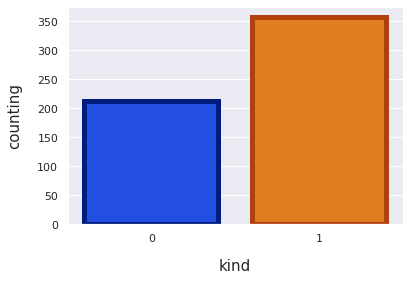

In [3]:
# 画图的顺序
# 这里主要是绘制出横纵坐标即可，因为我们的类别已经放在横坐标里面了
# 我倒不建议直接给出图标的标题（指在写论文的过程中），除非直接把标题绘制在图标的下方
def PlotCount(data, x_label, y_label):
    sns.countplot(data, linewidth=5,  edgecolor=sns.color_palette("dark", 2), palette="bright")
    
    plt.xlabel(x_label, size=15, labelpad=15)
    plt.ylabel(y_label, size=15, labelpad=15)

PlotCount(labels, "kind", "counting")

# 二. 研究各个标签下同一个特征中值的分布
这个也是比较重要的一环，做好这一步将为我们后来的特征工程打上良好的基础。<br>
比如我们研究年龄对标签的分布，结果发现某一个年龄段中正标签的数目特别多，那就会为我们特征工程提供思路。<br>

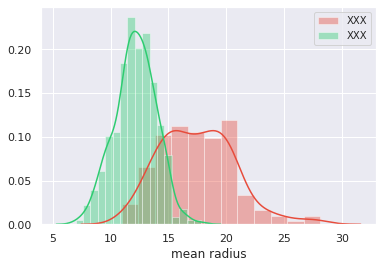

In [4]:
# 一般而言我们只绘制二分类问题的图像
# 不然所有分类全部绘制在一张图上会显得非常难看
def PlotDist(data_set, labels, feature):
    categories = labels.unique()
    # 返回相应的索引，在numpy的基础上只要传入逻辑表达式就行了
    indexes1 = labels == categories[0]
    indexes2 = labels == categories[1]
    # 绘制
    sns.distplot(data_set[feature][indexes1], label='XXX', hist=True, color='#e74c3c')
    sns.distplot(data_set[feature][indexes2], label='XXX', hist=True, color='#2ecc71')
    # 图例
    plt.legend(loc='upper right', prop={'size': 10})
    # 显示
    plt.show()
   
PlotDist(data_set, labels, 'mean radius')

# 三. 研究各个变量之间的相关性
在做EDA的时候，我们也要研究变量之间的相关性，这也是为了我们之后的工作做铺垫。<br>
比如我们在补全缺失值的时候，有时不应该利用整个数据集，而应该利用数据集上的某些，相关系数比较大的特征。<br>
绘制相关特征之间相关性的图叫做**热力图**，热力图共有两种画法：
1. seaborn里面的**矩形热力图**。
2. ML-ensemble里面的**三角形热力图**。<br>
接下来我将给大家展示这几个热力图

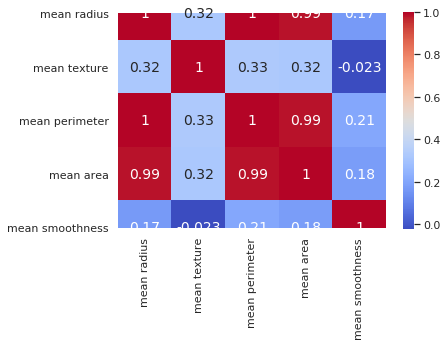

In [5]:
# Seaborn里面的画法
# 使用了coolwarm以后，这个图看得就比较清楚了
sns.heatmap(data_set.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

[MLENS] backend: threading


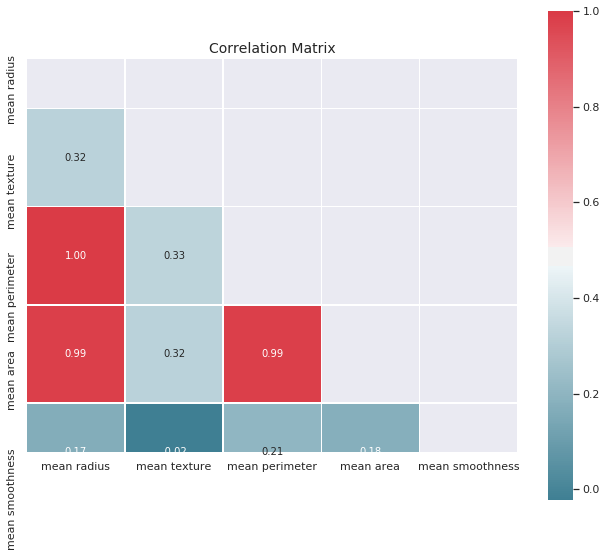

In [6]:
# mlen里面的画法
from mlens.visualization import corrmat

corrmat(data_set.corr(), inflate=False)

# 四. 绘制learning curve
如果是sklearn内置的模型的话，我们甚至不需要费尽心机在训练的过程中找对应的metrics（不过其实也无法找，因为训练的过程已经被封装好了）
<br>所以要绘制learning curve的话，还需要专门的API

In [7]:
from sklearn.ensemble import RandomForestClassifier

# 注意，下面完全是错误的调包方法，仅仅是为了演示
rfc = RandomForestClassifier(random_state=0,max_depth=3)
rfc.fit(data_set, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

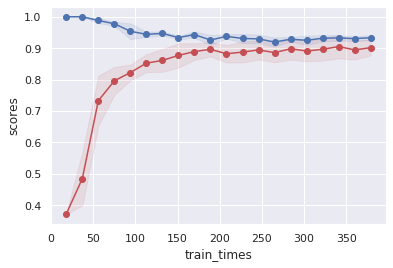

In [8]:
from sklearn.model_selection import learning_curve

def PlotLearningCurve(estimator, X, y):
    # 盲猜这个train_size是训练次数，至于这个train_score和这个test_score难道是不同训练下的答案
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, train_sizes=np.linspace(0.05, 1, 20)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # train_size是训练的样本数，fill_between还要额外接受两个参数(上限和下限)
    # 注意fill_between要设置透明度, 不然就直接和learning_curve混在一起了
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                     alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                     alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, "o-", color="b")
    plt.plot(train_sizes, test_scores_mean, "o-", color="r")
    
    plt.xlabel("train_times")
    plt.ylabel("scores")
    plt.show()

PlotLearningCurve(rfc, data_set, labels)

# 五. 绘制各个特征之间的重要性图
这一步往往是在我们已经用baseline拟合了训练集以后做的。<br>
他的目的就是做进一步的特征工程。

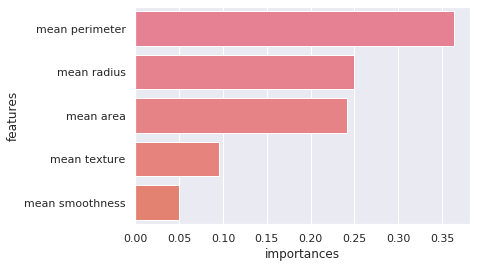

In [9]:
# 你要知道features_importances_返回的仅仅是一个列表而已
# 为了获得相应的特征，我们得从中构造一个
def PlotImportances(data_set, importances):
    features_importances = pd.DataFrame({"features": data_set.columns, "importances": importances},
                                       index=data_set.columns)
    features_importances.sort_values(by='importances', inplace=True, ascending=False)
    sns.barplot(x= "importances", y="features", data=features_importances)

    
PlotImportances(data_set, rfc.feature_importances_)

# 六. 绘制ROC曲线
机器学习中一个重要的metrics就是roc曲线，这里我们直接把k-fold cross validation和roc结合在一起绘制。
<br>不过ROC曲线有一个局限性就是只能作用于二分类问题。见下:

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(labels, rfc.predict_proba(data_set)[:, 1])
fprs = [fpr] * 2
tprs = [tpr] * 2

0.9788858939802336
0.9788858939802336


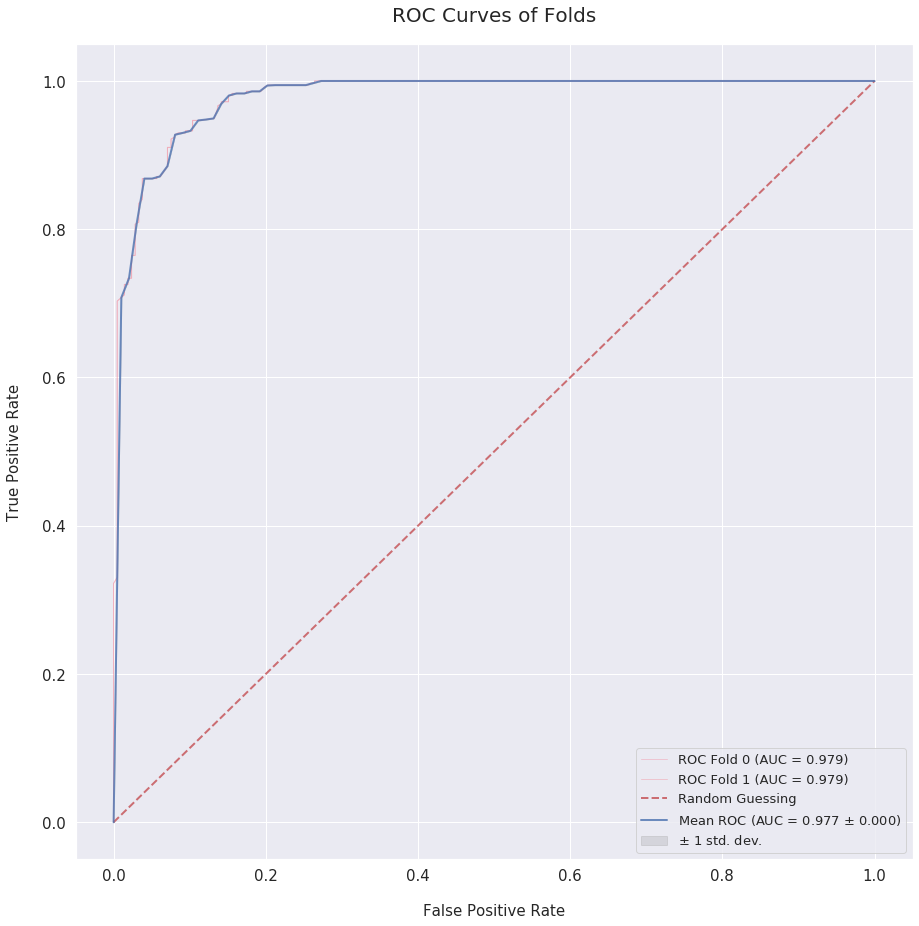

In [11]:
def PlotROCCurve(fprs, tprs): 
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    # 绘制每一折的ROC和计算对应的AUC
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        print(roc_auc)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
    # 绘制随机的ROC曲线
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # 计算平均ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # 在平面上绘制对应的标准差
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

PlotROCCurve(fprs, tprs)